# **CALIFORNIA HOUSING PRICE**

**##LATAR BELAKANG**

Dataset California Housing ini berisi data sensus perumahan dari tahun 1990 dan mencakup berbagai fitur seperti jumlah kamar tidur, kepadatan penduduk, dan jarak ke pantai, serta target variabel median_house_value yang merepresentasikan nilai rata-rata rumah dalam satu blok. Dataset ini sangat relevan untuk digunakan dalam membangun model regresi karena bersifat numerik dan representatif terhadap variabel-variabel real estat yang umum dianalisis. Dengan pendekatan supervised learning, khususnya regresi, kita dapat membangun model prediktif yang mampu memperkirakan nilai rumah di berbagai wilayah California secara akurat.

**## RUMUSAN MASALAH**



1.Fitur (variabel) apa saja yang memiliki pengaruh signifikan terhadap nilai median rumah di wilayah California?

2.Seberapa akurat model regresi yang dibangun dalam memprediksi nilai rumah, dan algoritma mana yang memberikan hasil terbaik

3.Seberapa baik performa model regresi yang dibangun dalam memprediksi nilai rumah, dan bagaimana akurasinya diukur menggunakan metrik evaluasi seperti MAE, RMSE, dan R²?





##**TUJUAN**


1.Menentukan fitur atau variabel yang berpengaruh signifikan terhadap nilai median rumah di wilayah California

2.Mengevaluasi akurasi model regresi dalam memprediksi nilai rumah dan membandingkan kinerja algoritma yang digunakan

3.Mengukur dan menganalisis performa model regresi menggunakan metrik evaluasi seperti MAE, RMSE, dan R²

## DATA UNDERSTANDING

#Feature
| Nama Kolom           | Tipe    | Deskripsi Singkat                               |
| -------------------- | ------- | ----------------------------------------------- |
| `longitude`          | float64 | Garis bujur lokasi rumah                        |
| `latitude`           | float64 | Garis lintang lokasi rumah                      |
| `housing_median_age` | float64 | Usia median rumah di area tersebut              |
| `total_rooms`        | float64 | Jumlah total ruangan di blok tersebut           |
| `total_bedrooms`     | float64 | Jumlah total kamar tidur                        |
| `population`         | float64 | Jumlah penduduk di area tersebut                |
| `households`         | float64 | Jumlah rumah tangga di area tersebut            |
| `median_income`      | float64 | Pendapatan median (dalam puluhan ribu dolar)    |
| `ocean_proximity`    | object  | Kedekatan dengan laut (kategori geografis)      |
| `median_house_value` | float64 | Nilai median rumah (target yang umum digunakan) |

##**LIBRARY**

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
import missingno
import folium
from sklearn.model_selection import KFold, RandomizedSearchCV
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson

###**Exploratory Data Analysis**

In [81]:
df = pd.read_csv('data_california_house.csv')

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14448 entries, 0 to 14447
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14448 non-null  float64
 1   latitude            14448 non-null  float64
 2   housing_median_age  14448 non-null  float64
 3   total_rooms         14448 non-null  float64
 4   total_bedrooms      14311 non-null  float64
 5   population          14448 non-null  float64
 6   households          14448 non-null  float64
 7   median_income       14448 non-null  float64
 8   ocean_proximity     14448 non-null  object 
 9   median_house_value  14448 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.1+ MB


In [83]:
min_price = df['median_house_value'].min()
max_price = df['median_house_value'].max()
colormap = plt.get_cmap('plasma')  # Menggunakan plt.get_cmap untuk peta warna

# Membuat peta
latitude_center = df['latitude'].mean()
longitude_center = df['longitude'].mean()
map = folium.Map(location=[latitude_center, longitude_center], zoom_start=7)

# Mengambil sampel dari data untuk mengurangi jumlah titik yang divisualisasikan
sampled_df = df.sample(frac=0.2, random_state=1)  # Menampilkan 20% dari data agar filesize ipynb tidak terlalu besar

# Menambahkan CircleMarker dengan warna berdasarkan harga
for index, row in sampled_df.iterrows():
    # Normalisasi harga agar berada di antara 0 dan 1
    norm_price = (row['median_house_value'] - min_price) / (max_price - min_price)

    # Menggunakan colormap untuk mendapatkan warna langsung, tanpa mcolors
    color = colormap(norm_price)  # Warna berupa tuple (r, g, b, a)

    # Mengonversi warna (r, g, b, a) menjadi HEX
    hex_color = '#{:02x}{:02x}{:02x}'.format(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))

    # Tambahkan CircleMarker dengan radius lebih kecil dan tanpa tooltip untuk reduksi filesize
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # Mengurangi radius
        color=hex_color,
        fill=True,
        fill_color=hex_color,
        fill_opacity=0.7  # Mengurangi opacity untuk visualisasi lebih sederhana
    ).add_to(map)

map

Gambar tersebut menunjukkan peta persebaran rumah di California berdasarkan koordinat geografis, di mana setiap titik mewakili lokasi properti, dan warna titik menunjukkan intensitas tertentu—kemungkinan besar harga rumah atau kepadatan populasi. Titik-titik paling padat dan berwarna terang (kuning atau merah) terlihat terkonsentrasi di sepanjang pesisir barat California, khususnya di sekitar Los Angeles, San Francisco, dan San Diego. Ini menandakan bahwa wilayah-wilayah tersebut memiliki nilai rumah yang relatif tinggi dibandingkan daerah lain. Sebaliknya, warna ungu tua yang mendominasi wilayah tengah hingga timur California menunjukkan bahwa rumah-rumah di area pedalaman cenderung memiliki harga yang lebih rendah atau kepadatan yang lebih sedikit. Secara keseluruhan, visualisasi ini menunjukkan bahwa harga rumah di California sangat dipengaruhi oleh lokasi geografis, terutama kedekatannya dengan pantai dan pusat kota besar. Ini juga menunjukkan bahwa fitur seperti latitude, longitude, dan ocean_proximity memiliki pengaruh signifikan dan bisa menjadi fitur penting jika ingin membangun model prediksi harga rumah di wilayah ini.

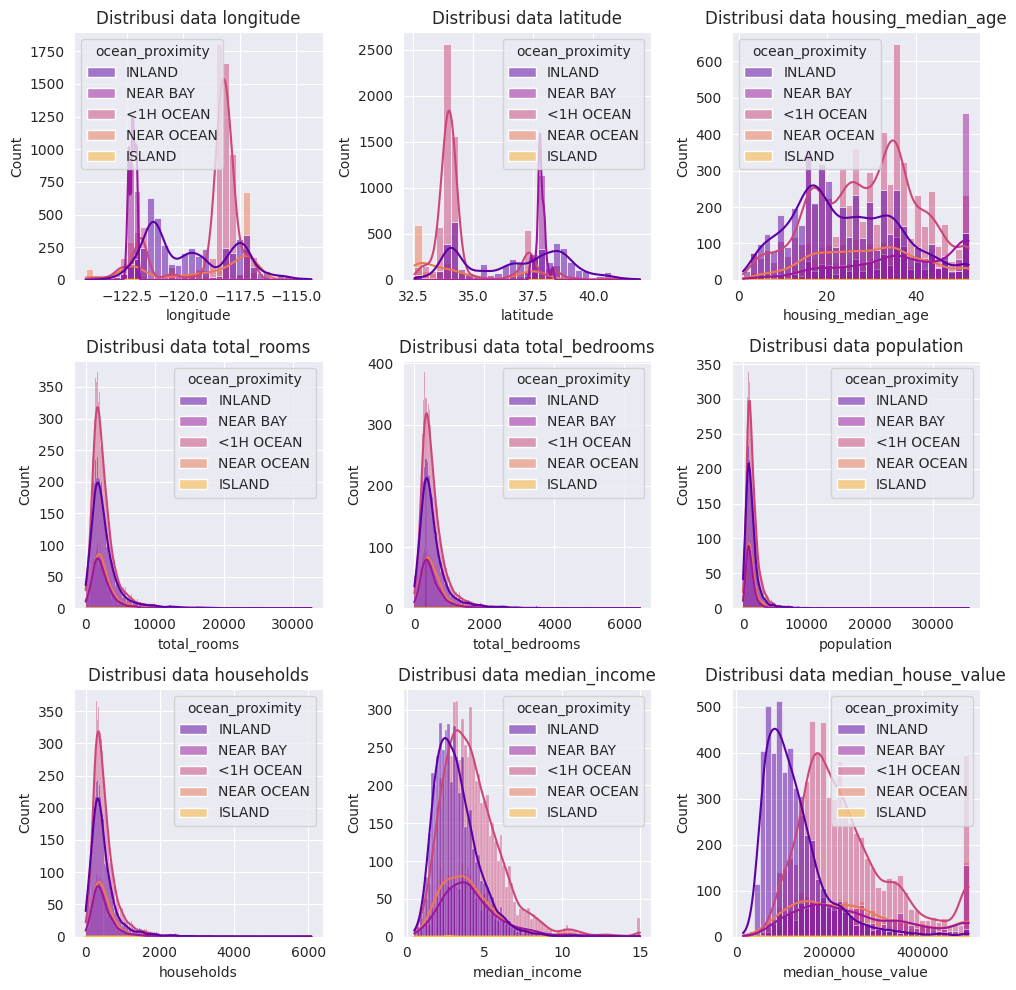

In [84]:
plt.figure(figsize=(10,10))
sns.set_style('darkgrid')
float_cols = [col for col in df.columns if df[col].dtypes == 'float64']
for i, col in enumerate(float_cols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df, x=col, hue='ocean_proximity', palette='plasma', kde=True)
    plt.title(f"Distribusi data {col}")

plt.tight_layout()
plt.show()

Distribusi median_income cukup beragam, tetapi daerah “INLAND” lebih banyak dihuni oleh penduduk dengan pendapatan menengah ke bawah, sedangkan daerah “NEAR OCEAN” dan “<1H OCEAN” cenderung memiliki distribusi pendapatan yang lebih lebar dan rata. Terakhir, distribusi median_house_value menunjukkan bahwa harga rumah di wilayah “NEAR OCEAN” dan “<1H OCEAN” cenderung lebih tinggi dibandingkan wilayah “INLAND”, yang sebagian besar rumahnya berada di kisaran harga yang lebih rendah. Selain itu, terdapat batas atas yang terlihat jelas di nilai 500.000, menandakan kemungkinan batas maksimum data yang diinput (censoring).

Secara keseluruhan, analisis ini menunjukkan bahwa kedekatan dengan laut sangat memengaruhi karakteristik rumah dan lingkungan sekitarnya, baik dari segi nilai properti, kepadatan populasi, maupun tingkat pendapatan.

## **Preprocessing Data**

## CEK MISSING VALUE, MISSING PERCENT, UNIQUECOUNT DAN SAMPLE VALUES

In [85]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['Column', 'Dtype', 'MissingValues', 'MissingPercent', 'UniqueCount', 'SampleValues'],
                      data=listItem)

dfDesc

,Column,Dtype,MissingValues,MissingPercent,UniqueCount,SampleValues
0,longitude,float64,0,0.00,806,"[-118.79, -116.55]"
1,latitude,float64,0,0.00,836,"[33.24, 37.18]"
2,housing_median_age,float64,0,0.00,52,"[11.0, 14.0]"
3,total_rooms,float64,0,0.00,5227,"[11294.0, 2465.0]"
4,total_bedrooms,float64,137,0.95,1748,"[942.0, 112.0]"
5,population,float64,0,0.00,3498,"[2434.0, 414.0]"
6,households,float64,0,0.00,1649,"[584.0, 19.0]"
7,median_income,float64,0,0.00,9797,"[3.5054, 4.4205]"
8,ocean_proximity,object,0,0.00,5,"[INLAND, NEAR BAY]"
9,median_house_value,float64,0,0.00,3548,"[265000.0, 90700.0]"


<Axes: >

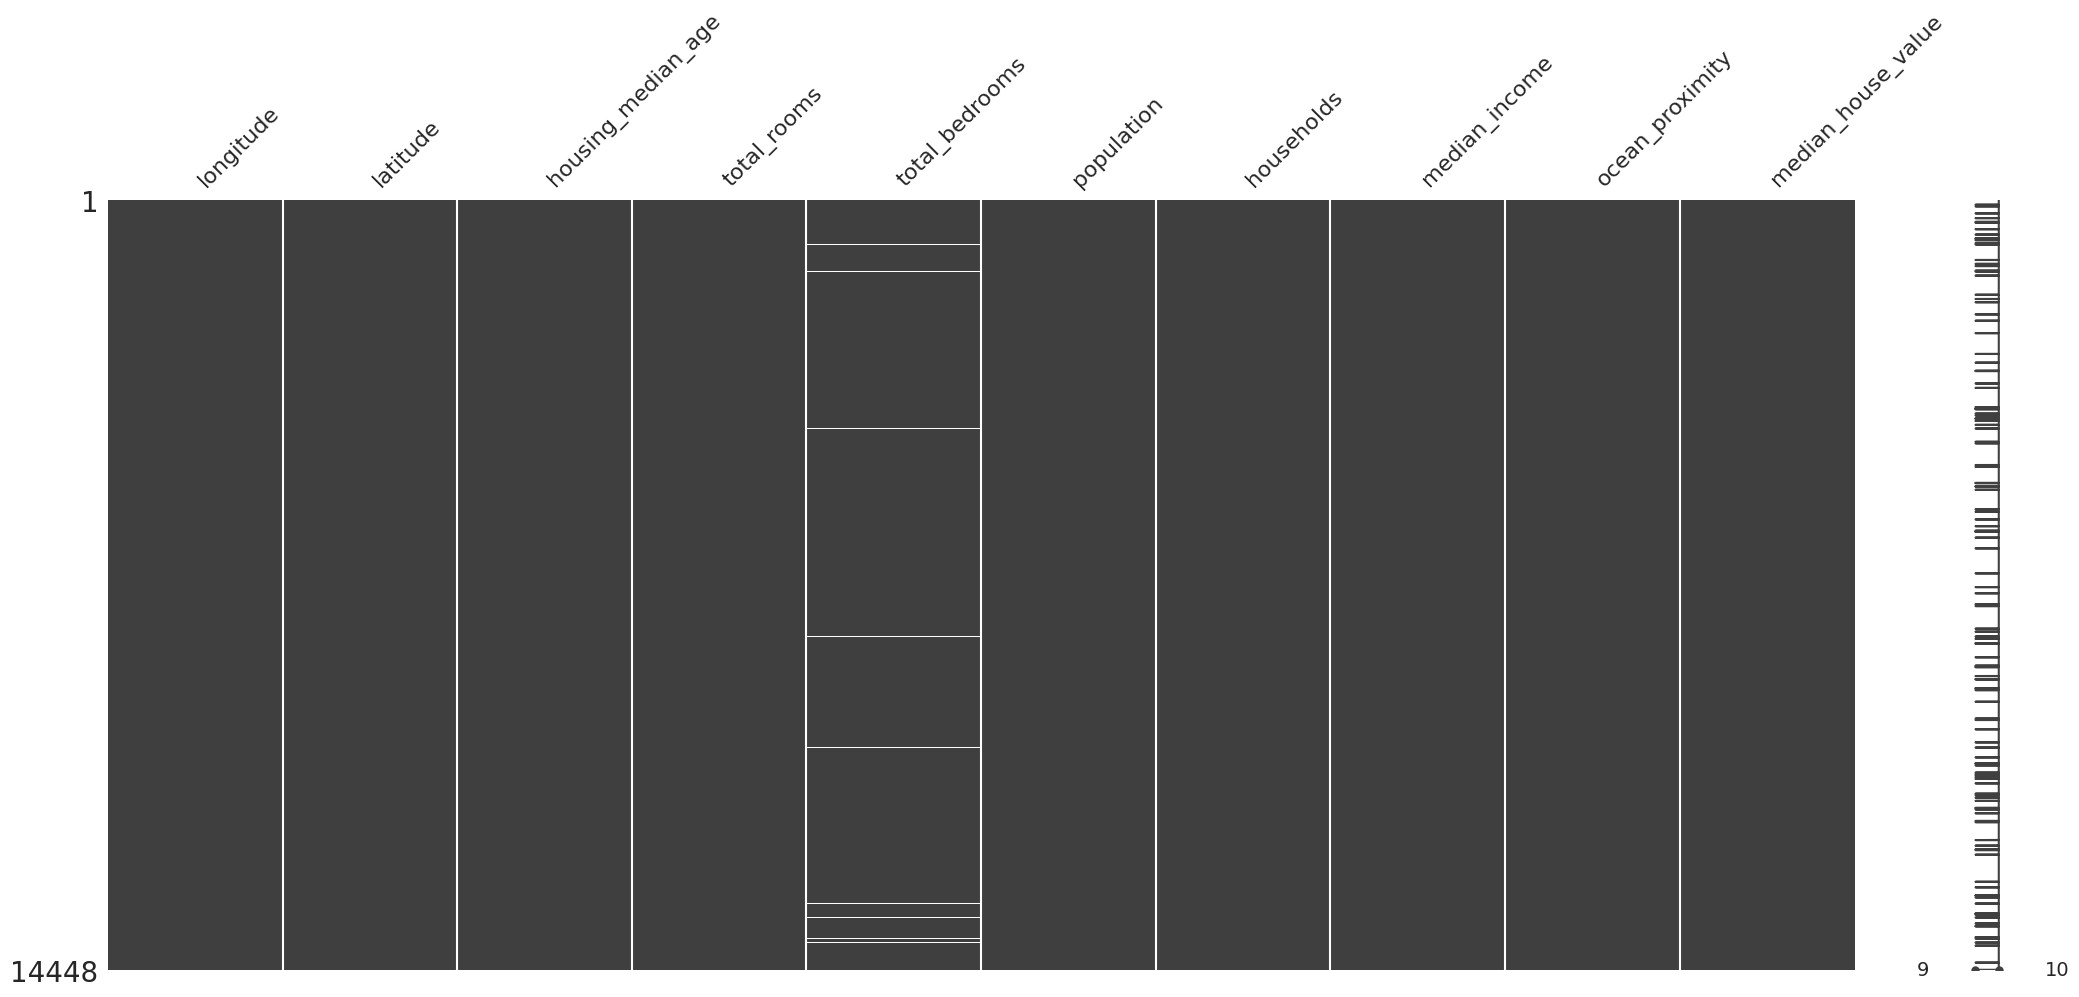

In [86]:
missingno.matrix(df)

In [87]:
df['total_bedrooms'] = df.groupby('total_rooms')['total_bedrooms'].transform(lambda x: x.fillna(x.median()))

In [88]:
df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)

<ipython-input-88-c9f555b11c0f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)


<Axes: >

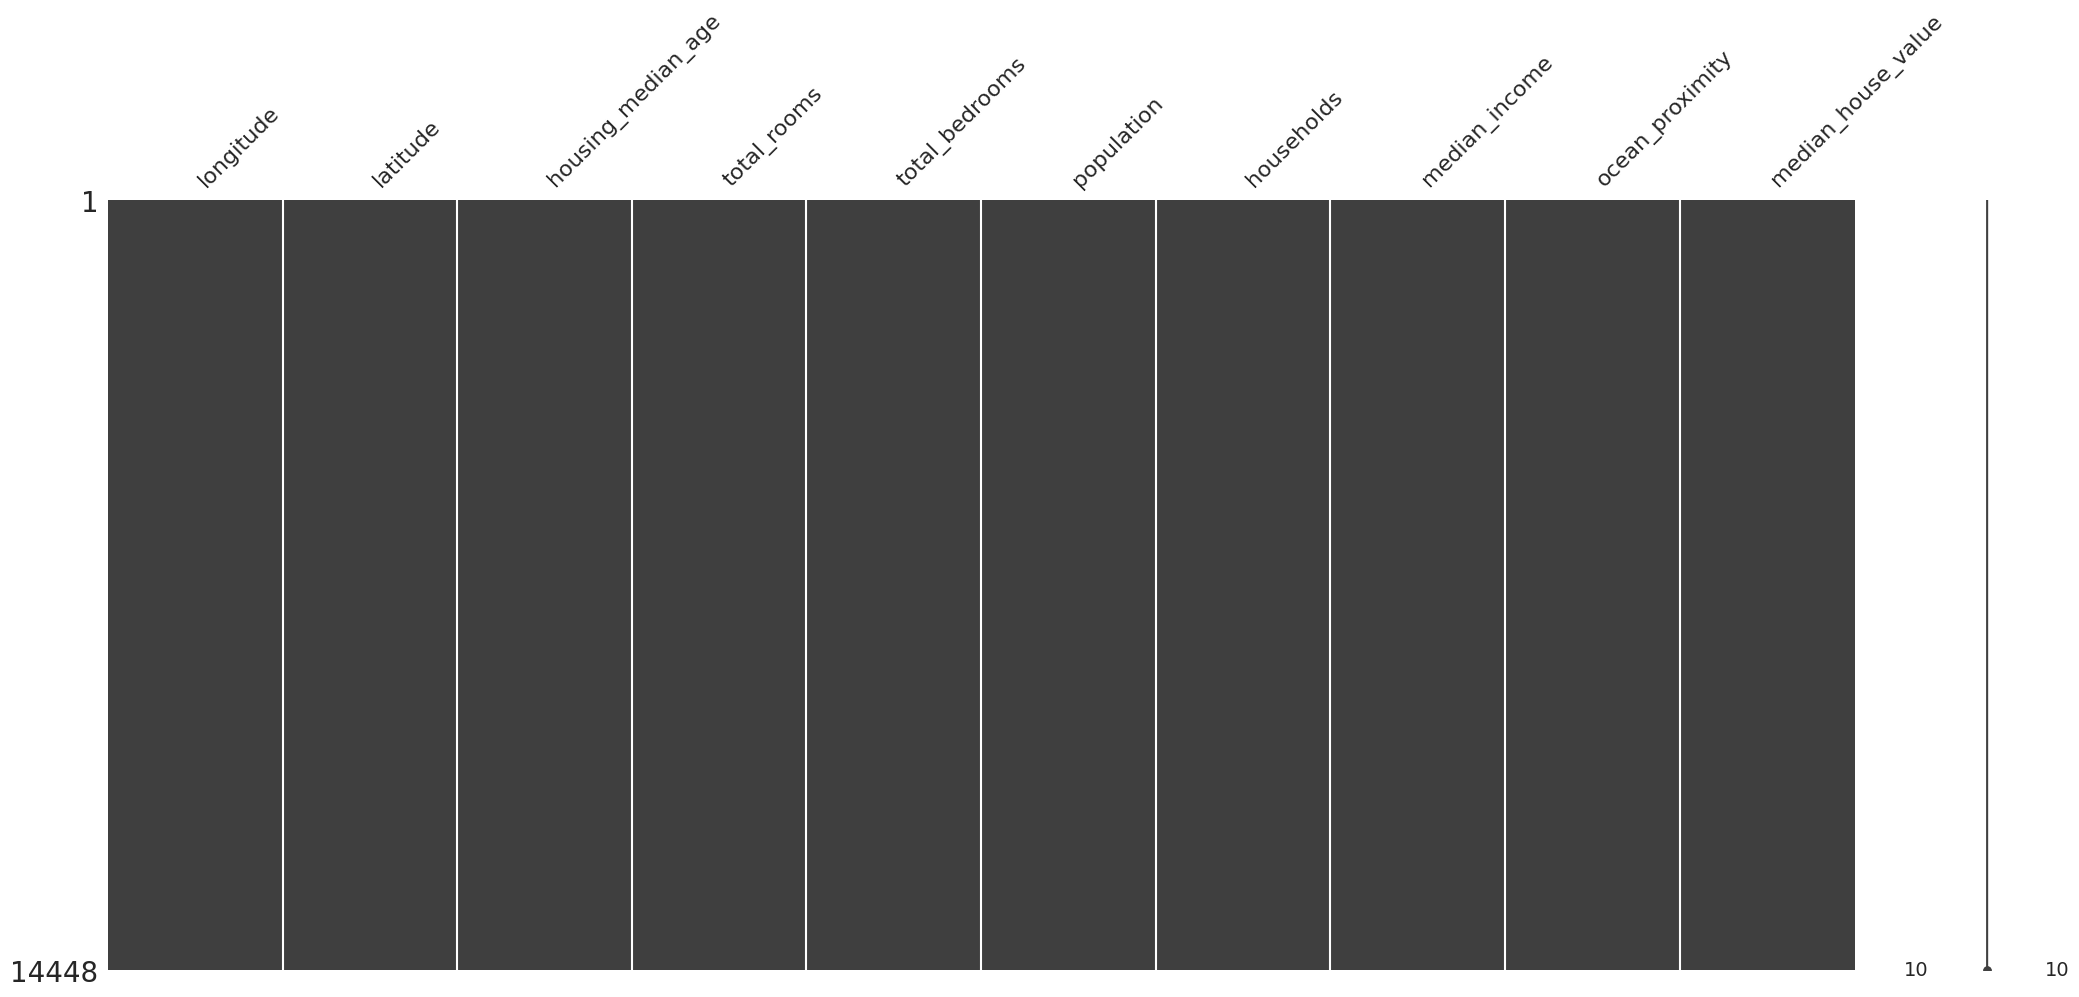

In [89]:
missingno.matrix(df)

In [90]:
df.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
ocean_proximity,0
median_house_value,0


#**MENGECEK DATA DUPLIKAT**

In [91]:
df.duplicated().sum()

np.int64(0)

## OUTLIER DATA

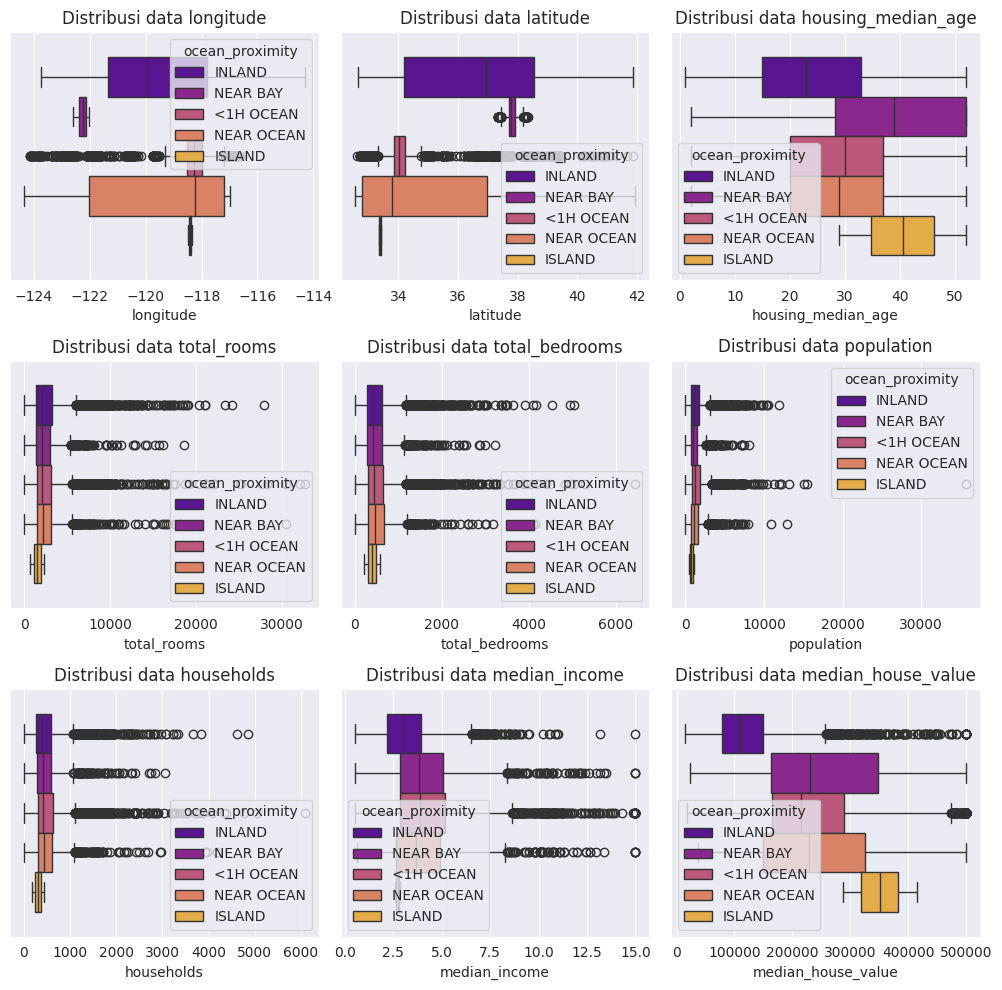

In [92]:
plt.figure(figsize=(10,10))
sns.set_style('darkgrid')
float_cols = [col for col in df.columns if df[col].dtypes == 'float64']
for i, col in enumerate(float_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(df, x=col, hue='ocean_proximity', palette='plasma')
    plt.title(f"Distribusi data {col}")

plt.tight_layout()
plt.show()

Pada fitur total_rooms, total_bedrooms, population, dan households, tampak jelas adanya sejumlah nilai ekstrem yang berada jauh di luar rentang interkuartil (IQR), terutama pada kategori <1H OCEAN dan NEAR OCEAN. Nilai-nilai tersebut mencerminkan properti dengan jumlah kamar, populasi, dan rumah tangga yang sangat tinggi, yang tidak umum dan berpotensi menjadi outlier.

Sementara itu, variabel housing_median_age, longitude, dan latitude menunjukkan distribusi yang lebih terkonsentrasi tanpa adanya outlier yang signifikan, mencerminkan konsistensi usia rumah dan lokasi geografis. Fitur median_income dan median_house_value juga menunjukkan adanya outlier, khususnya pada nilai-nilai yang sangat tinggi, yang perlu dianalisis lebih lanjut karena dapat memengaruhi performa model jika tidak ditangani dengan tepat.

In [93]:
df['median_house_value'].describe()

,median_house_value
count,14448.000000
mean,206824.624516
std,115365.476182
min,14999.000000
25%,119600.000000
50%,180000.000000
75%,263900.000000
max,500001.000000


<Axes: xlabel='median_house_value'>

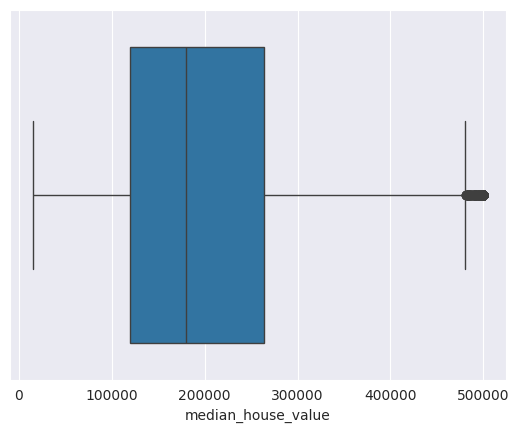

In [94]:
sns.boxplot(x=df['median_house_value'])

In [95]:
df = df.drop(df[df['median_house_value'] == 500001].index)

Menghapus nilai 500001 untuk membuat distribusi data normal pada kolom Median House VALUE

In [96]:
df['median_house_value'].describe()

,median_house_value
count,13770.000000
mean,192389.360712
std,97589.825606
min,14999.000000
25%,116700.000000
50%,174000.000000
75%,248000.000000
max,500000.000000


In [97]:
df['housing_median_age'].describe()

,housing_median_age
count,13770.000000
mean,28.356064
std,12.504354
min,1.000000
25%,18.000000
50%,28.000000
75%,37.000000
max,52.000000


In [98]:
df['housing_median_age'].value_counts()

,count
housing_median_age,
52.0,770
36.0,554
35.0,550
16.0,514
17.0,493
34.0,466
33.0,413
26.0,411
18.0,390


<Axes: xlabel='housing_median_age'>

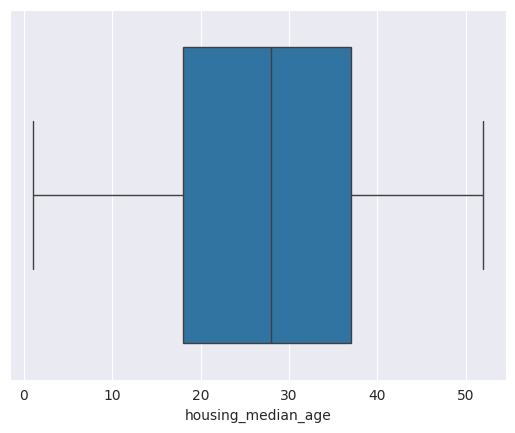

In [99]:
sns.boxplot(x=df['housing_median_age'])

In [100]:
df = df.drop(df[df['housing_median_age'] == 1].index)

Menghapus nilai 1 pada [Housing_Median_age] dikarenakan hanya memiliki 2 data agar membuat data terdistribusi normal

In [101]:
df['housing_median_age'].describe()

,housing_median_age
count,13768.000000
mean,28.360038
std,12.500914
min,2.000000
25%,18.000000
50%,28.000000
75%,37.000000
max,52.000000


In [102]:
def find_outliers(df):
    for col in df:
        if df[col].dtypes == 'float64':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    return df

df_clean = find_outliers(df)
df_clean.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0
7,-121.26,38.69,17.0,3917.0,638.0,1809.0,564.0,5.2586,INLAND,137000.0


Berfungsi untuk mengidentifikasi dan menghapus outliers dalam dataset dengan menggunakan metode Interquartile Range (IQR). Fungsi ini memeriksa kolom numerik (tipe data float64) dalam DataFrame, menghitung kuartil pertama (Q1) dan ketiga (Q3), serta IQR untuk menentukan rentang nilai yang normal. Nilai yang berada di luar rentang ini dianggap sebagai outliers dan dihapus. Hasil akhirnya adalah DataFrame yang bersih dari nilai ekstrem yang dapat mempengaruhi analisis atau model.

In [103]:
df['ocean_proximity'] = df['ocean_proximity'].replace('ISLAND', 'NEAR OCEAN')

Replace 'ISLAND' dengan 'NEAR OCEAN' (or another suitable category) karna ISLAND kategori hanya memiliki 2 data

##**PENAMBAHAN FEATURE BARU**

In [104]:
df_clean['room_per_household'] = round(df_clean['total_rooms']/df_clean['households'],1)
df_clean['room_per_capita'] = round(df_clean['total_rooms']/df_clean['population'],1)
df_clean['bed_room_ratio'] = round(df_clean['total_bedrooms']/df_clean['total_rooms'],1)
df_clean.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value,room_per_household,room_per_capita,bed_room_ratio
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0,2.8,0.6,0.2
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0,3.7,1.2,0.3
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0,6.5,1.7,0.2
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0,4.6,1.3,0.3
7,-121.26,38.69,17.0,3917.0,638.0,1809.0,564.0,5.2586,INLAND,137000.0,6.9,2.2,0.2


Kolom room_per_household menunjukkan rata-rata jumlah ruangan per rumah tangga di suatu wilayah, yang memberikan gambaran tentang kelapangan tempat tinggal. Semakin tinggi nilainya, semakin besar kemungkinan rumah tersebut memiliki ukuran yang luas. Kolom room_per_capita menggambarkan jumlah ruangan per individu, yang berguna untuk mengukur kepadatan hunian per orang—nilai rendah bisa mengindikasikan kondisi padat atau sempit. Sementara itu, kolom bed_room_ratio adalah rasio antara jumlah kamar tidur terhadap total ruangan, yang menunjukkan proporsi ruang dalam rumah yang difungsikan sebagai kamar tidur. Nilai ini bisa merefleksikan fungsi tata ruang dalam rumah di suatu wilayah. Ketiga fitur ini sangat berguna untuk membantu model machine learning menangkap pola kehidupan dan kualitas hunian lebih baik dibanding hanya menggunakan fitur asli.

## CORRELATION DATA

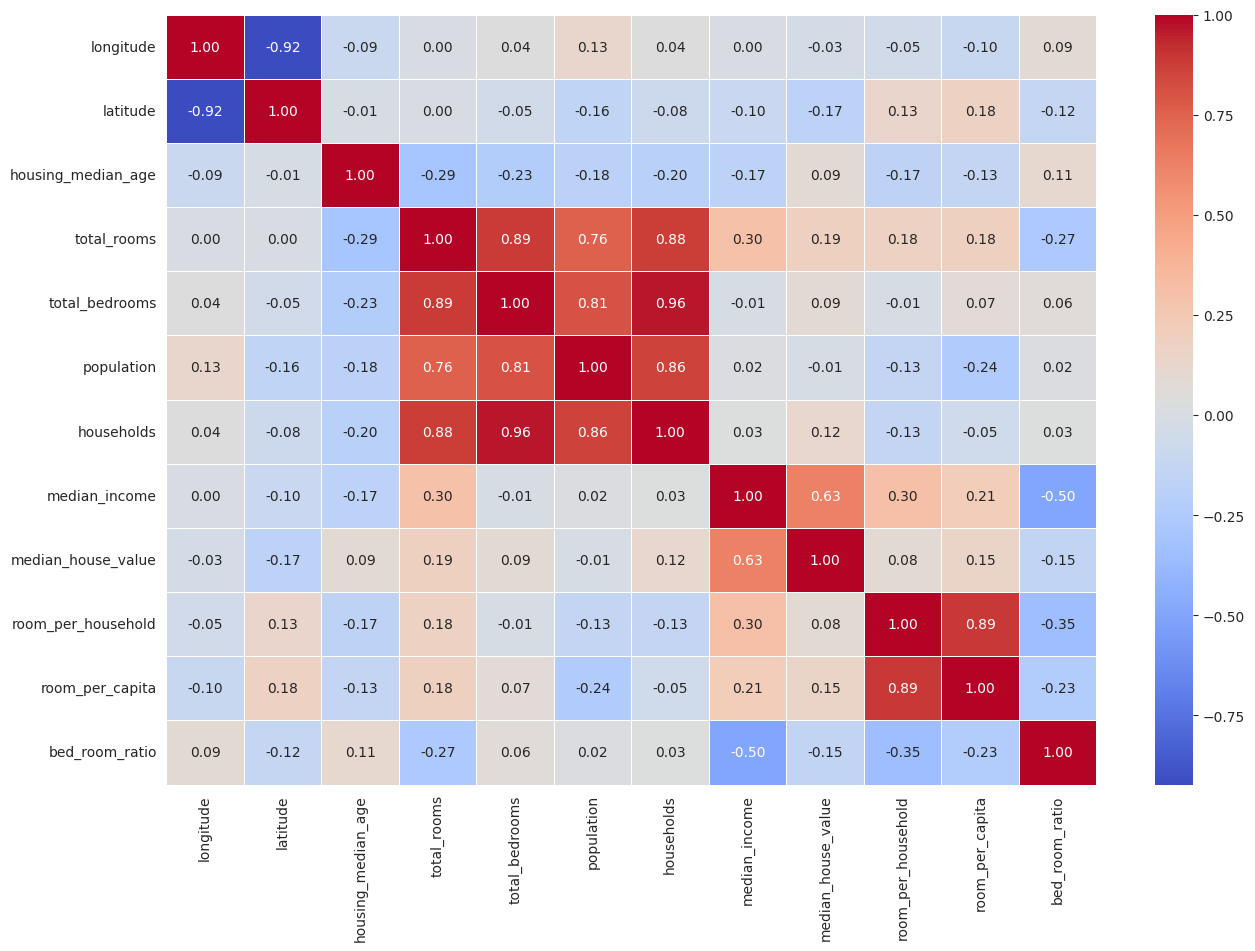

In [105]:
numeric_df = df_clean.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(15, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

##**FEATURE ENGGINERING**

In [106]:
# Preprocessing pipeline
numeric_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                    'total_bedrooms', 'population', 'households', 'median_income','room_per_household','room_per_capita','bed_room_ratio']
categorical_features = ['ocean_proximity']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

1.Fitur numerik seperti longitude, latitude, housing_median_age, total_rooms, dll., akan ditransformasi menggunakan StandardScaler.

2.Fitur kategorikal yaitu ocean_proximity akan dikodekan menggunakan OneHotEncoder.

3.Kedua jenis fitur ini digabung menggunakan ColumnTransformer



In [107]:
# Pisahkan fitur dan target
X = df_clean.drop('median_house_value', axis=1)
y = df_clean['median_house_value']

1. Kolom median_house_value digunakan sebagai variabel target (y).
2. Fitur lainnya disiapkan sebagai variabel input (X), dan data kemudian dibagi menjadi data pelatihan dan pengujian menggunakan fungsi train_test_split



In [108]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [109]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

In [110]:
for name, regressor in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"{name}:")
    print(f"  R-squared = {r2:.3f}")
    print(f"  MAE = {mae:.3f}")
    print(f"  RMSE = {rmse:.3f}\n")


Linear Regression:
  R-squared = 0.624
  MAE = 40903.075
  RMSE = 54203.518

Ridge Regression:
  R-squared = 0.624
  MAE = 40868.507
  RMSE = 54171.354

Lasso Regression:
  R-squared = 0.624
  MAE = 40902.695
  RMSE = 54202.864



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.279e+12, tolerance: 7.246e+09
  model = cd_fast.enet_coordinate_descent(


Decision Tree:
  R-squared = 0.597
  MAE = 37913.024
  RMSE = 56108.900

Random Forest:
  R-squared = 0.784
  MAE = 28311.011
  RMSE = 41076.859

XGBoost:
  R-squared = 0.803
  MAE = 26885.551
  RMSE = 39184.385



Random Forest merupakan model dengan performa terbaik karena menghasilkan nilai R-squared tertinggi (0.784) serta kesalahan prediksi terendah, baik pada metrik MAE (28.311) maupun RMSE (41.076). Hal ini menunjukkan bahwa model Random Forest mampu menjelaskan variasi data dengan lebih baik dan memberikan prediksi yang lebih akurat dibandingkan model lainnya.

Sementara itu, ketiga model regresi linier — Linear Regression, Ridge Regression, dan Lasso Regression — menunjukkan performa yang sangat mirip, dengan nilai R-squared sekitar 0.624 dan kesalahan prediksi yang relatif lebih tinggi dibandingkan Random Forest.

Model Decision Tree memang menunjukkan nilai MAE yang sedikit lebih rendah dibandingkan regresi linier, namun nilai R-squared-nya lebih rendah (0.597), yang mengindikasikan bahwa model ini kurang efektif dalam menjelaskan keseluruhan variasi data target.

Adapun model Lasso Regression menampilkan peringatan konvergensi (ConvergenceWarning), yang menandakan bahwa proses pelatihan belum mencapai konvergensi optimal.

##**PENGURANGAN FEATURE**

Berdasarkan Korelasi dari data california housing price, ditemukan total bad rooms memiliki korelasi yang tinggi sebesar 0.96. salah satu kolom ini dapat menyebabkan multikolinearitas, kita dapat menghapus kolom tersebut

In [111]:
numeric_features_clean = ['longitude', 'latitude', 'housing_median_age','population', 'households', 'median_income','room_per_household','room_per_capita','bed_room_ratio','total_rooms']
categorical_features_clean = ['ocean_proximity']

preprocessor_clean = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_clean),
        ('cat', OneHotEncoder(), categorical_features_clean)
    ])

In [112]:
df_clean = df_clean.drop('total_bedrooms', axis=1)

In [113]:
# Pisahkan fitur dan target
X = df_clean.drop('median_house_value', axis=1)
y = df_clean['median_house_value']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=43)

In [115]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(random_state=43),
    "Random Forest": RandomForestRegressor(random_state=43),
    "XGBoost": XGBRegressor(random_state=43)
}

In [116]:
for name, regressor in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor_clean),
        ('regressor', regressor)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"{name}:")
    print(f"  R-squared = {r2:.3f}")
    print(f"  MAE = {mae:.3f}")
    print(f"  RMSE = {rmse:.3f}\n")


Linear Regression:
  R-squared = 0.631
  MAE = 40360.402
  RMSE = 53932.043

Ridge Regression:
  R-squared = 0.630
  MAE = 40378.955
  RMSE = 53973.848

Lasso Regression:
  R-squared = 0.631
  MAE = 40360.809
  RMSE = 53932.763



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.245e+12, tolerance: 7.229e+09
  model = cd_fast.enet_coordinate_descent(


Decision Tree:
  R-squared = 0.579
  MAE = 38997.097
  RMSE = 57624.613

Random Forest:
  R-squared = 0.791
  MAE = 28175.734
  RMSE = 40558.208

XGBoost:
  R-squared = 0.806
  MAE = 27101.457
  RMSE = 39049.831



Dari prediksi diatas kita dapat meningkatkan prediksi score di XGboost sebesar 0,03% dan mengurangi nilai RMSE dan MAE dapat disimpulkan bahwa pada saat menghapus kolom yang mengandung nilai multikolinearitas mampu menambah perediksi score

##**HYPER TUNNING**

Karena model XGBoost memiliki performa yang lebih baik dibanding model  yang lain, maka selanjutnya kita akan menggunakan model XGBoost ini sebagai model akhir. Pada tahap ini, kita akan melakukan hyperparameter tuning pada model XGBoost dengan harapan dapat meningkatkan performa model.

In [117]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

In [118]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=1))
])

In [119]:
# Kedalaman pohon
max_depth = list(np.arange(1, 11))

# Learning rate
learning_rate = list(np.arange(1, 100)/100)

# Jumlah pohon
n_estimators = list(np.arange(100, 201))

# Jumlah baris tiap pohon (% dari total baris train set)
subsample = list(np.arange(2, 10)/10)

# Gamma (min_impurity_decrease)
gamma = list(np.arange(1, 11)) # Semakin besar nilainya, semakin konservatif/simpel modelnya

# Jumlah feature yang digunakan untuk tiap pohon (% dari total kolom train set)
colsample_bytree = list(np.arange(1, 10)/10)

# Alpha (regularization)
reg_alpha = list(np.logspace(-3, 1, 10)) # Semakin besar nilainya, semakin konservatif/simpel modelnya


# Hyperparam space XGboost
param_distributions = {
    'regressor__max_depth': max_depth,
    'regressor__learning_rate': learning_rate,
    'regressor__n_estimators': n_estimators,
    'regressor__subsample': subsample,
    'regressor__gamma': gamma,
    'regressor__colsample_bytree': colsample_bytree,
    'regressor__reg_alpha': reg_alpha
}

In [120]:
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring={
        'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
        'neg_mean_absolute_error': 'neg_mean_absolute_error',
        'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error'
    },
    refit='neg_root_mean_squared_error',  # model terbaik akan dipilih berdasarkan RMSE
    n_jobs=-1,
    verbose=1,
    random_state=1
)


In [121]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['longitude',
                                                                                'latitude',
                                                                                'housing_median_age',
                                                                                'total_rooms',
                                                                                'population',
                                                                                'households',
                                                                                'median_income',
                                                                                'room_per_household',
                                                                                'room_per_capita',
                                                                                'bed_room_ratio']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['o...
                                                                 np.float64(0.4),
                                                                 np.float64(0.5),
                                                                 np.float64(0.6),
                                                                 np.float64(0.7),
                                                                 np.float64(0.8),
                                                                 np.float64(0.9)]},
                   random_state=1, refit='neg_root_mean_squared_error',
                   scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error',
                            'neg_root_mean_squared_error': 'neg_root_mean_squared_error'},
                   verbose=1)

In [122]:
tuning_results = pd.DataFrame(random_search.cv_results_).sort_values(
    by=[
        'rank_test_neg_root_mean_squared_error',
        'rank_test_neg_mean_absolute_error',
        'rank_test_neg_mean_absolute_percentage_error'
    ]
)

In [123]:
tuning_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__subsample,param_regressor__reg_alpha,param_regressor__n_estimators,param_regressor__max_depth,param_regressor__learning_rate,param_regressor__gamma,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
7,0.797670,0.006990,0.019995,0.000188,0.9,0.059948,119,8,0.05,5,...,770.001028,1,-0.167324,-0.166442,-0.174802,-0.177441,-0.171486,-0.171499,0.004224,1
3,0.685685,0.086289,0.038286,0.010172,0.5,0.021544,166,8,0.10,9,...,592.903823,2,-0.179922,-0.183636,-0.189289,-0.181426,-0.187131,-0.184281,0.003486,2
17,0.371169,0.013660,0.020864,0.007438,0.6,0.001000,190,5,0.04,9,...,567.875064,3,-0.180538,-0.183522,-0.184844,-0.190462,-0.184033,-0.184680,0.003236,3
8,0.391121,0.005622,0.018953,0.000472,0.7,0.021544,182,6,0.31,2,...,709.058697,4,-0.186668,-0.184778,-0.194417,-0.188446,-0.188761,-0.188614,0.003232,4
13,0.576802,0.148752,0.027667,0.001116,0.6,0.059948,171,9,0.18,4,...,564.051429,6,-0.197553,-0.200718,-0.206220,-0.197357,-0.200549,-0.200479,0.003204,6


In [124]:
# Cek skor dan parameter terbaik dari hasil tuning
print('XGBoost')
print('Best_score:', random_search.best_score_)
print('Best_params:', random_search.best_params_)

XGBoost
Best_score: -39890.689930933884
Best_params: {'regressor__subsample': np.float64(0.9), 'regressor__reg_alpha': np.float64(0.05994842503189409), 'regressor__n_estimators': np.int64(119), 'regressor__max_depth': np.int64(8), 'regressor__learning_rate': np.float64(0.05), 'regressor__gamma': np.int64(5), 'regressor__colsample_bytree': np.float64(0.8)}


Hasil tuning parameter memberikan kombinasi terbaik, seperti max_depth = 8, yang menunjukkan kedalaman pohon yang cukup untuk menangkap kompleksitas data tanpa terlalu dalam hingga berisiko overfitting. Learning rate yang kecil (0.05) membuat proses pelatihan menjadi lebih hati-hati, dan membantu dalam meningkatkan generalisasi model. Selain itu, nilai subsample = 0.9 dan colsample_bytree = 0.8 berarti bahwa model menggunakan 90% data dan 80% fitur secara acak pada setiap pohon, yang merupakan strategi yang baik untuk menghindari overfitting. Nilai gamma = 5 menambah batasan agar pembelahan pohon dilakukan hanya jika ada pengurangan loss yang signifikan, menjadikan model lebih konservatif. Sementara itu, reg_alpha = 0.0599 memberikan sedikit penalti L1, yang membantu dalam regularisasi agar model tidak terlalu kompleks.

In [125]:
# Model XGBoost (referensi awal saja)
model = {'XGB': XGBRegressor(random_state=1)}

# Gunakan model terbaik hasil tuning
xgb_tuning = random_search.best_estimator_

# Fit ulang ke data training
xgb_tuning.fit(X_train, y_train)

# Prediksi data test
y_pred_xgb_tuning = xgb_tuning.predict(X_test)

# Hitung metrik evaluasi
rmse_xgb_tuning = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuning))
mae_xgb_tuning = mean_absolute_error(y_test, y_pred_xgb_tuning)
mape_xgb_tuning = mean_absolute_percentage_error(y_test, y_pred_xgb_tuning)

# Simpan hasil skor ke dalam DataFrame
score_after_tuning = pd.DataFrame({
    'RMSE': [rmse_xgb_tuning],
    'MAE': [mae_xgb_tuning],
    'MAPE': [mape_xgb_tuning]
}, index=model.keys())

# Tampilkan hasil
score_after_tuning

,RMSE,MAE,MAPE
XGB,37765.396435,26202.89757,0.160144


In [126]:
# Setelah hyperparameter tuning
score_after_tuning

,RMSE,MAE,MAPE
XGB,37765.396435,26202.89757,0.160144


Model XGBoost menunjukkan performa yang cukup baik dan stabil, dengan:

1.Tingkat kesalahan rata-rata sekitar 16% (MAPE), yang menunjukkan bahwa prediksi model relatif akurat.

2.Nilai RMSE dan MAE yang wajar tergantung pada skala data target. Jika nilai target berada dalam kisaran ratusan ribu, maka nilai-nilai ini masih tergolong rendah.

3.Perbedaan antara RMSE dan MAE juga menunjukkan bahwa model tidak terlalu terpengaruh oleh outlier (selisih tidak terlalu besar antara RMSE dan MAE).

Model ini layak dipertimbangkan untuk digunakan dalam sistem prediksi, dan bisa lebih ditingkatkan lagi dengan analisis residual serta validasi pada data uji untuk memastikan generalisasi.

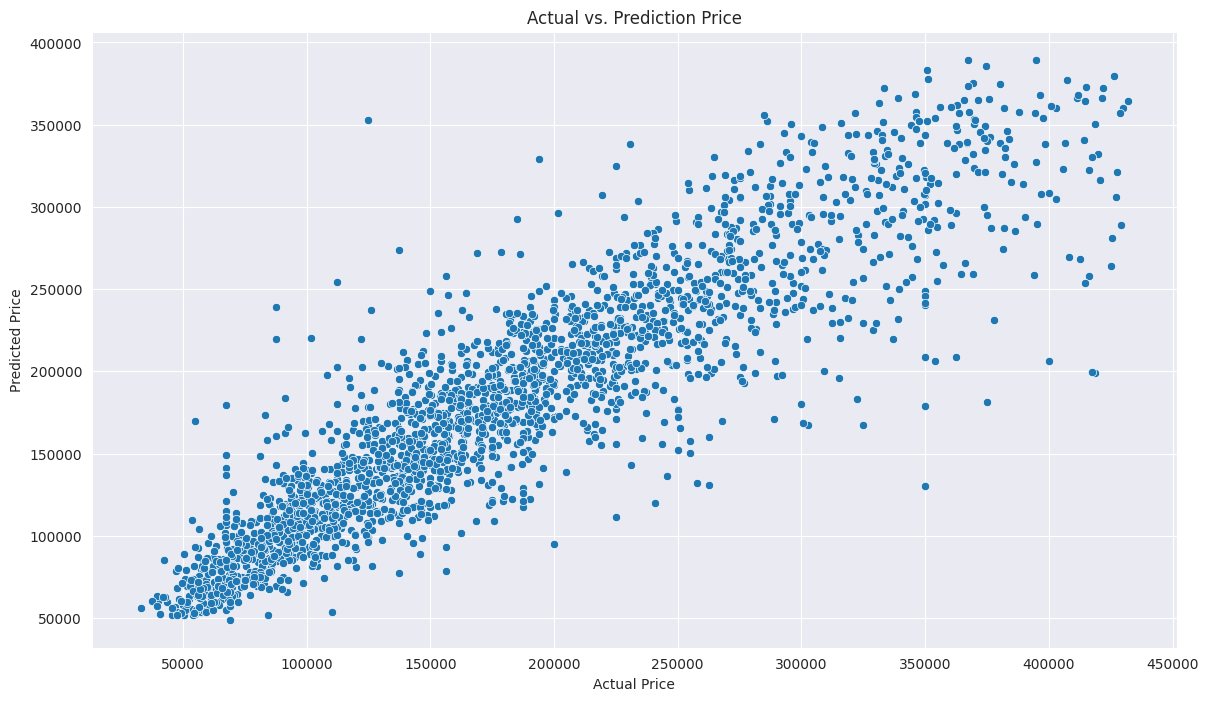

In [127]:
plt.figure(figsize=(14, 8))
plot = sns.scatterplot(x=y_test, y=y_pred_xgb_tuning).set(title='Actual vs. Prediction Price',
                                               xlabel='Actual Price',
                                               ylabel='Predicted Price');

Titik-titik pada grafik menunjukkan pola linear yang cukup jelas dari kiri bawah ke kanan atas. Ini mengindikasikan bahwa model XGBoost berhasil menangkap hubungan yang kuat antara variabel input dan harga aktual, karena semakin tinggi nilai aktual, prediksinya juga ikut meningkat.

Visualisasi ini menunjukkan bahwa model XGBoost cukup andal dan akurat dalam memprediksi harga. Sebagian besar prediksi berada dalam kisaran yang wajar dan dekat dengan nilai aktual, meskipun terdapat beberapa penyimpangan pada harga tinggi.

##**FEATURE IMPORTANCES**

In [128]:
model = pipeline.named_steps['regressor']

In [129]:
xgb_model = xgb_tuning.named_steps['regressor']
preprocessor = xgb_tuning.named_steps['preprocessor']

In [130]:
feature_importances = pd.DataFrame(
    xgb_model.feature_importances_,
    index=preprocessor.get_feature_names_out(),
    columns=['Coefficients']
).sort_values('Coefficients', ascending=False)

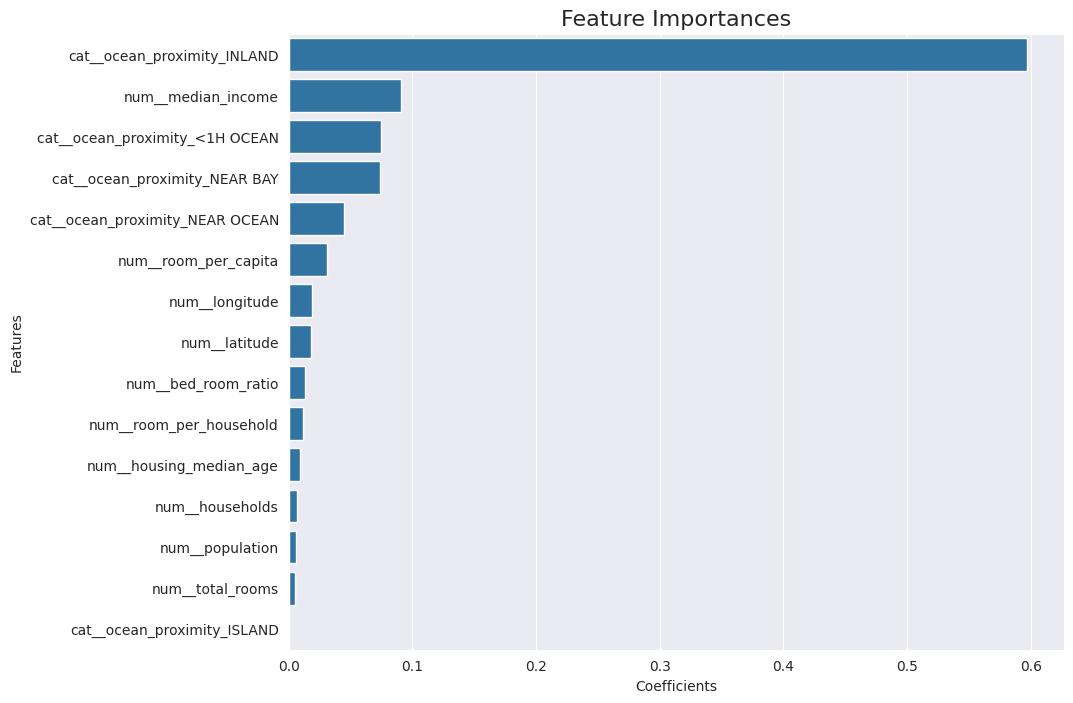

In [131]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficients', y=feature_importances.index, data=feature_importances)
plt.title('Feature Importances', fontsize=16)
plt.xlabel('Coefficients')
plt.ylabel('Features')
plt.show()

Dari gambar diatas dapat disimpulkan bahwa feature ocean_proximity_inland paling berpengaruh kepada prediksi mode

## **RESIDUAL ANALISIS**

In [132]:
residuals = y_test - y_pred

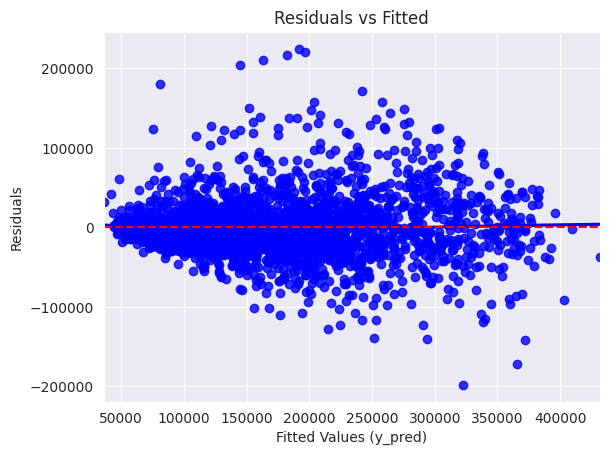

In [133]:
sns.residplot(x=y_pred, y=residuals, lowess=True, color='blue')
plt.xlabel("Fitted Values (y_pred)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.axhline(0, color='red', linestyle='--')
plt.show()

Model XGBoost menunjukkan performa yang baik dalam memodelkan data, dengan residual yang terdistribusi cukup merata dan tanpa pola tertentu. Meski terdapat indikasi ringan heteroskedastisitas dan beberapa outlier, hal ini tidak terlalu memengaruhi kualitas prediksi secara keseluruhan. Model dapat dikatakan cukup reliable untuk digunakan dalam prediksi harga dengan performa yang stabil.

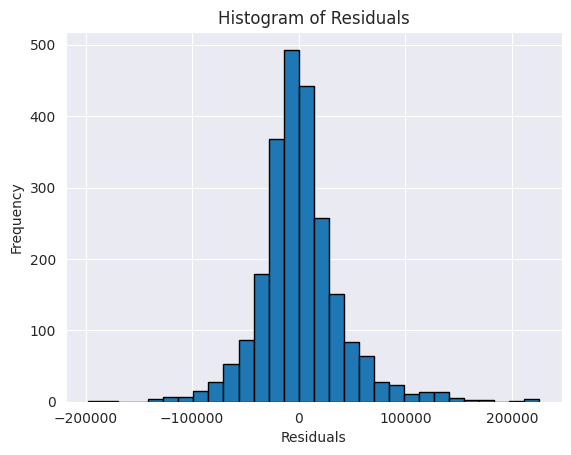

In [134]:
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

Histogram residual ini menunjukkan bahwa model XGBoost memiliki residual yang terdistribusi normal, yang merupakan salah satu karakteristik model regresi yang baik. Ini mendukung kesimpulan sebelumnya bahwa model bekerja cukup optimal dan prediksinya dapat dipercaya untuk sebagian besar kasus.

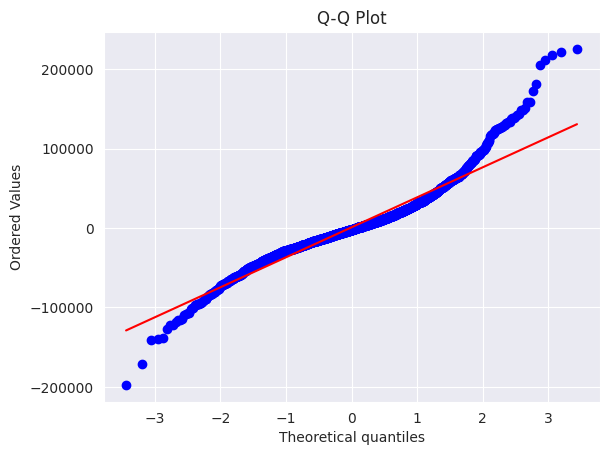

In [135]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

Q-Q plot ini memperkuat hasil dari histogram residual sebelumnya:

Model cukup baik dalam memprediksi nilai karena residualnya mendekati distribusi normal.

In [136]:
dw = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw}")

Durbin-Watson Statistic: 1.972608532420364


Durbin-Watson (DW) statistic digunakan untuk mendeteksi adanya autokorelasi (khususnya autokorelasi orde pertama) dalam residual dari regresi.

Nilai DW berkisar antara 0 hingga 4.

Nilai sekitar 2 menunjukkan tidak ada autokorelasi.

Nilai < 2 menunjukkan adanya autokorelasi positif.

Nilai > 2 menunjukkan adanya autokorelasi negatif.

Dengan nilai DW = 1.9726, yang sangat dekat dengan 2, maka:

 Tidak terdapat autokorelasi yang signifikan pada residual model. Ini menunjukkan bahwa asumsi independensi residual terpenuhi, dan model regresi yang digunakan dapat dianggap valid dari sisi autokorelasi residual.

#**KESIMPULAN**

Berdasarkan pemodelan yang telah dilakukan terhadap dataset California Housing, fitur-fitur seperti median_income dan housing_median_age terbukti menjadi variabel yang paling berpengaruh terhadap median_house_value. Hal ini menunjukkan bahwa tingkat pendapatan masyarakat dan usia bangunan merupakan indikator utama dalam menentukan nilai properti di California.


Model XGBoost menunjukkan performa yang cukup baik dan stabil setelah dilakukan hyperparameter tuning. Nilai evaluasi model menunjukkan bahwa tingkat kesalahan rata-rata (MAPE) berada di kisaran 16%, yang mengindikasikan bahwa prediksi harga rumah oleh model tergolong cukup akurat. Nilai RMSE sebesar 37.765 dan MAE sebesar 26.202 juga terbilang wajar, mengingat skala harga rumah yang berada pada kisaran ratusan ribu dolar. Perbedaan yang tidak terlalu besar antara RMSE dan MAE mengindikasikan bahwa model tidak terlalu sensitif terhadap outlier, dan memiliki stabilitas yang baik dalam melakukan prediksi.


 Nilai Durbin-Watson sebesar 1.97 juga menunjukkan bahwa tidak terdapat autokorelasi yang signifikan dalam residual model, sehingga model bisa dianggap stabil.

#**REKOMENDASI**

Mengevaluasi prediksi dengan error tertinggi. Kita bisa membagi hasil prediksi menjadi tiga grup berdasarkan error-nya, yaitu:

1.Overestimation (5% prediksi yang terlalu tinggi)

Underestimation (5% prediksi yang terlalu rendah)

Grup mayoritas (90% prediksi dengan error mendekati rata-rata)

Setelah pembagian ini, kita bisa menganalisis korelasi antara error dengan fitur-fitur independen seperti median_income, housing_median_age, atau ocean_proximity. Tujuannya adalah mengidentifikasi apakah ada pola khusus yang menyebabkan model sering meleset, sehingga kita bisa melakukan feature engineering lebih lanjut untuk memperbaikinya.

<br>

2.Menambahkan fitur baru yang relevan dan korelatif dengan harga rumah. Beberapa fitur potensial yang bisa ditambahkan jika tersedia, antara lain:

- Luas bangunan atau luas tanah

- Akses terhadap fasilitas umum (jarak ke sekolah, rumah sakit, atau pusat kota)

- Indeks kriminalitas daerah

- Nilai pajak properti

Selain itu, menggunakan data California Housing terbaru juga bisa meningkatkan akurasi model, khususnya dalam menangkap tren harga rumah yang berubah dari waktu ke waktu.

<br>


3.Jika dataset diperluas, misalnya dengan penggabungan data properti di berbagai wilayah atau dengan informasi historis, maka penggunaan model yang lebih kompleks seperti ensemble stacking, neural networks, atau bahkan RNN (jika ada data sekuensial seperti harga per bulan) dapat dieksplorasi. Namun, untuk dataset statis seperti California Housing yang tersedia saat ini, model XGBoost atau Random Forest biasanya sudah cukup optimal.

<br>

4.Model yang sudah dibangun dapat dikembangkan untuk kebutuhan prediksi lain. Misalnya, prediksi perubahan harga rumah dalam beberapa tahun ke depan berdasarkan tren ekonomi, inflasi, dan perkembangan infrastruktur. Model seperti ini bisa memanfaatkan data eksternal seperti:

- Laju pertumbuhan penduduk

- Data pembangunan jalan tol atau transportasi umum baru

- Tren pasar properti di masing-masing kabupaten/kota

Jika tersedia kolom seperti recent_price_change atau data penjualan berulang dari rumah yang sama, kita bahkan bisa membangun model time series untuk memprediksi tren harga di masa depan, yang sangat berguna bagi agen properti dan investo

##**SAVE MODEL**

In [141]:
import pickle

estimator = Pipeline([('preprocess', preprocessor), ('model', XGBRegressor())])
estimator.fit(X_train, y_train)

pickle.dump(estimator, open('California_Housing_Price.sav', 'wb'))

In [138]:
filename = 'California_Housing_Price.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [139]:
np.sqrt(mean_squared_error(y_test, loaded_model.predict(X_test)))

np.float64(39032.40800715618)